# 画像メディア工学５回目
## 5. 周波数領域におけるフィルタリング（フーリエ変換）
### ライブラリの読み込み（おまじない）

In [257]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

### 5.1 １次元データのフーリエ変換
画像のフーリエ変換（２次元フーリエ変換）の前に，フーリエ変換の簡単な説明として１次元データのフーリエ変換．

### Sin波の合成のフーリエ変換
例では，$y = 1 + 3 \sin(x) + 2 \sin(5 x)$

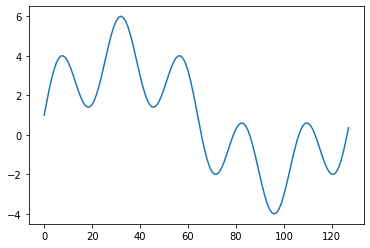

In [308]:
N = 128   # サンプル数
dx = 2*np.pi/N
x = np.arange(0, 2*np.pi, dx)   # 0～2πまでのN個の配列

w1 = 1    # 1つ目の周波数
w2 = 5    # 2つ目の周波数

a0 = 1    # 直流成分
a1 = 3    # 1つ目の周波数
a2 = 2    # 2つ目の周波数

y = a0 + a1*np.sin(w1*x) + a2*np.sin(w2*x)   # 2つのsin信号の合成

plt.plot(y);

### フーリエ変換（１次元フーリエ変換）
np.fft.fft()関数でできる

In [259]:
F = np.fft.fft(y)

### 結果の表示

0，1，７にピーク (＝直流と$\sin(x)$, $\sin(7x)$からなるという意味）

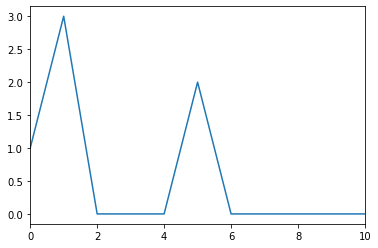

In [260]:
# 振幅の計算
amp = np.abs(F)/(N/2)
amp[0] = amp[0]/2

# 振幅スペクトルのプロット
plt.plot(amp)

# グラフのx軸の範囲を設定
# この設定を加えると，低周波部分のみのグラフが描画
plt.xlim(0,10);

### 5.2 画像のフーリエ変換

### Google colaboratoryで利用する場合の画像のアップロード
変換対象の画像はなんでも良いです．

In [261]:
#from google.colab import files
#uploaded_file = files.upload()

アップロードした画像の読み込み

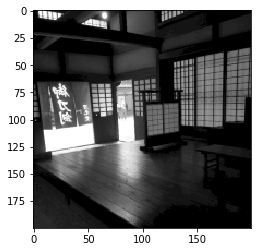

In [262]:
img = cv2.imread('img03.png', 0);  # モノクロ画像として読み込み
plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)

### 画像のフーリエ変換
`np.fft.fft2()` 関数を用いる

In [263]:
fimg = np.fft.fft2(img)

### 振幅スペクトル描画の関数
振幅スペクトル描画の前に，振幅スペクトルの計算などの前処理が必要なため，関数として定義しておく（詳細は気にしなくても良いです）

plt_fft_result()関数:
- fimg: np.fft.fft2()の結果
- 出力: 振幅スペクトルのプロット

In [264]:
def plot_fft_result(fimg):
    fimg[np.abs(fimg)<1] = 1             # 振幅スペクトル計算時のエラー回避
    fimg_shift =  np.fft.fftshift(fimg)  # 直流成分を画像の左上から中心に移動    
    mag = 20*np.log(np.abs(fimg_shift))  # 強度スペクトルの計算
    
    plt.imshow(mag, cmap = 'gray')
    plt.title('Amplitude spectrum')

実行すると，

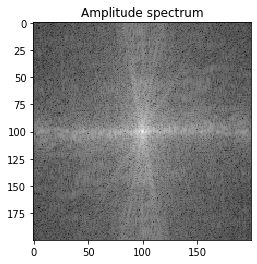

In [265]:
plot_fft_result(fimg)

### 振幅スペクトルから画像の復元（逆フーリエ変換）
`np.fft.ifft()` 関数を利用する．

In [266]:
ifft_img = np.fft.ifft2(fimg)

逆フーリエ変換の結果を描画する際には，実部(ifft_img.real)のみを指定する．

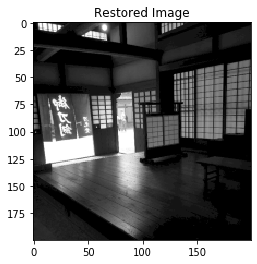

In [267]:
plt.imshow(ifft_img.real, cmap = 'gray')
plt.title('Restored Image');

### 5.3 周波数領域におけるフィルタリング
上の振幅スペクトル画像に対して処理を行ってから逆フーリエ変換をすることで，周波数領域でのフィルタリングが実現できる．
こちらも前処理などがあるため，関数を定義しておく．（詳細は気にしなくても良いです）

freq_filtering()関数:
- fimg: 振幅スペクトル画像（np.fft.fft2()の出力）
- filter: フィルタ
- 戻り値: フィルタと周波数フィルタリング結果の描画

In [300]:
def freq_filtering(fimg, filter):
    fimg_shift = np.fft.fftshift(fimg)  # 直流成分を画像の左上から中心へと移動
    fimg_shift = fimg_shift * filter    # スペクトル画像に対してfilterをかける
    ifft_img = np.fft.ifft2(np.fft.ifftshift(fimg_shift)) # 逆フーリエ変換

    fimg_shift[np.abs(fimg_shift)<1] = 1    # log計算時のエラー対策（log0にしない）
    mag = 20*np.log(np.abs(fimg_shift))  # 強度スペクトルの計算
    
    plt.subplot(121)
    plt.imshow(filter, cmap = 'gray')
    plt.title('Filter')
    plt.subplot(122)
    plt.imshow(mag, cmap = 'gray')
    plt.title('Filtered Spectrum')
    plt.show()    
    
    return ifft_img.real # 実部のみが必要

実行してみる

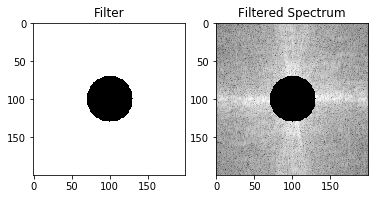

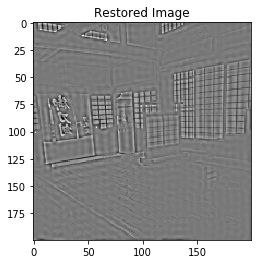

In [256]:
# フーリエ変換結果の配列サイズ（＝元画像サイズ）と画像中心の座標取得
w, h = fimg.shape
cx, cy = int(h/2), int(w/2)

# ローパスフィルタの定義
low_pass = np.zeros((w,h), dtype=np.uint8) # フーリエ変換結果と同じサイズの配列を作成（中身は全てゼロ） 
cv2.circle(low_pass, (cx,cy), 30, 1, -1)  # フィルタ画像に，(cx,cy)を中心とした半径30，明るさ1の円を描く)

# ハイパスフィルタの定義
high_pass = np.ones((w,h), dtype=np.uint8) # フーリエ変換結果と同じサイズの配列を作成（中身は全て１）
cv2.circle(high_pass, (cx,cy), 30, 0, -1)  # フィルタ画像に，(cx,cy)を中心とした半径30，明るさ0の円を描く)

# フィルタの処理
filtered = freq_filtering(fimg, high_pass)

# 逆フーリエ変換結果の描画
plt.imshow(filtered, cmap = 'gray')
plt.title('Restored Image');

### 課題１
以下のプログラムを変更し，
1. 縦縞の画像
2. 横縞の画像
が出力されるようにしてください．

修正が必要な部分は、
- 変数Th（ローパス・ハイパスフィルタの周波数の閾値）の値
- ローパスフィルタ・ハイパスフィルタのどちらを適用するか
の２カ所です．

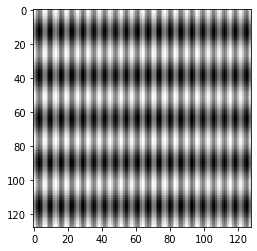

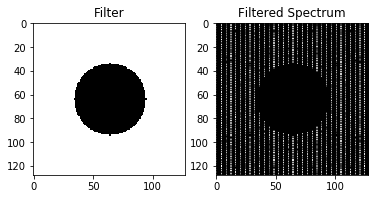

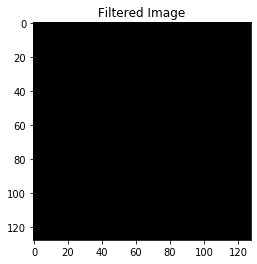

In [307]:
img2 = cv2.imread('img04.png', 0);  # モノクロ画像として読み込み
plt.imshow(img2, cmap='gray', vmin = 0, vmax = 255)
plt.show() # 画像表示

fimg2 = np.fft.fft2(img2)

# ローパス・ハイパスフィルタの閾値（この値を変化させてください）
Th = 30

# ローパスフィルタ・ハイパスフィルタの定義
w2, h2 = fimg2.shape
cx2, cy2 = int(h2/2), int(w2/2)

low_pass2 = np.zeros((w2,h2), dtype=np.uint8)
cv2.circle(low_pass2, (cx2,cy2), Th, 1, -1)

high_pass2 = np.ones((w2,h2), dtype=np.uint8)
cv2.circle(high_pass2, (cx2,cy2), Th, 0, -1)

# フィルタの処理 (ローパス・ハイパスのいずれかを適用するようにコメントを外してください)
#filtered2 = freq_filtering(fimg2, low_pass2) # ローパスフィルタを適用
filtered2 = freq_filtering(fimg2, high_pass2) # ハイパスフィルタを適用

# 逆フーリエ変換結果の描画
plt.imshow(filtered2, cmap = 'gray', vmin=0, vmax=255)
plt.title('Filtered Image');

### 課題２
以下の画像はどういう処理をした画像でしょうか？

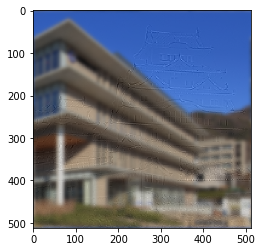